In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

from anguilla.optimizers.mocma import MOCMA, MOStoppingConditions, SuccessNotion
import anguilla.fitness.benchmark as benchmark

In [2]:
def population_plot(get_fn, n_parents=10, n_offspring=None,
                    n_trials=5, max_generations=None, max_evaluations=None,
                    success_notion=SuccessNotion.IndividualBased,
                    rng=None, initial_step_size=1.0, reference=None,
                    region_bounds=None, yscale='linear', xscale='linear',
                    plot_initial_fronts=True, plot_true_front=True, short_title=False):
    if n_offspring is None:
        n_offspring = n_parents
    # 1) Initialize storage
    initial = np.zeros((n_trials, n_parents, 2))
    final = np.zeros((n_trials, n_parents, 2))
    volumes = np.repeat(-1.0, n_trials)

    stopping_conditions = MOStoppingConditions(max_generations=max_generations, max_evaluations=max_evaluations)
    # 2) Run the trials
    for trial in range(n_trials):
        fn = get_fn(rng)
        fn.n_objectives = 2
        if fn.n_objectives != 2:
            raise ValueError("The provided function does not support 2 objectives")
        parent_points = fn.random_points(n_parents, region_bounds=region_bounds)
        parent_fitness = fn(parent_points)
        optimizer = MOCMA(parent_points, parent_fitness, n_offspring=n_offspring,
                          rng=rng, success_notion=success_notion, stopping_conditions=stopping_conditions)
        if reference is not None:
            optimizer.indicator.reference = reference
        initial[trial, :, :] = optimizer.best.fitness
        while not optimizer.stop.triggered:
            points = optimizer.ask()
            if fn.has_constraints:
                fitness, penalized_fitness = fn.evaluate_with_penalty(points)
                optimizer.tell(fitness, penalized_fitness)
            else:
                optimizer.tell(fn(points))
        final[trial, :, :] = optimizer.best.fitness
        volumes[trial] = optimizer.indicator(final[trial])

    # 3) Plot the results
    if plot_initial_fronts:
        fig = plt.figure(figsize=(8, 4))
        ax0, ax1 = fig.subplots(1, 2, sharey=True, sharex=True)
    else:
        fig = plt.figure(figsize=(4,4))
        ax1, ax0 = fig.subplots(1, 1), None
    if plot_true_front:
        # 3.1) Plot the true Pareto front for reference
        # Note: Not all benchmark functions implement 
        # the Pareto front function, hence the try/catch block
        try:
            front = fn.pareto_front()
            if plot_initial_fronts:
                ax1.plot(front[0], front[1], color='red', linestyle='-', label="True")
            ax0.plot(front[0], front[1], color='red', linestyle='-', label="True")
        except NotImplementedError:
            pass
    # 3.2) Plot the fronts obtained at the start and end of every trial
    for trial in range(n_trials):
        color, label = None, False
        for i in range(n_parents):
            if plot_initial_fronts:
                if color is None:
                    p = ax1.plot(initial[trial, i, 0], initial[trial, i, 1], marker='x')
                    color, label = p[0].get_color(), False
                else:
                    ax1.plot(initial[trial, i, 0], initial[trial, i, 1], marker='x', color=color, alpha=0.5)
            if color is None:
                p = ax0.plot(final[trial, i, 0], final[trial, i, 1], marker='x', color=color, alpha=0.5,
                           label=f"Trial {trial+1}")
                color, label = p[0].get_color(), True
            else:
                p = ax0.plot(final[trial, i, 0], final[trial, i, 1], marker='x', color=color, alpha=0.5,
                           label=f"Trial {trial+1}" if not label else None)
                label = True
    if not short_title:
        fig.suptitle("""Population plot for {}: $\mathbb{{R}}^{{{}}} \mapsto \mathbb{{R}}^{}$ using {}\n \
        for {} generations / {} evaluations in {} trials""".format(
            fn.qualified_name, fn.n_dimensions, fn.n_objectives, optimizer.qualified_name,
            optimizer.generation_count, optimizer.evaluation_count, n_trials,)
        )
    else:
        fig.suptitle("{} - {} evaluations".format(fn.name, fn.evaluation_count))
    ax0.set_title('Final front\n(max vol={:.6E})'.format(np.max(volumes)))
    ax0.set_ylabel('Second objective')
    ax0.set_xlabel('First objective')
    ax0.set_xscale(xscale)
    ax0.set_yscale(yscale)
    if plot_initial_fronts:
        ax1.set_title('Initial front\n(random points)')
        ax1.set_xscale(xscale)
        ax1.set_yscale(yscale)

    ax0.legend()
    fig.tight_layout()

    return fig

## ZDT benchmark

### ZDT1, $n=5$

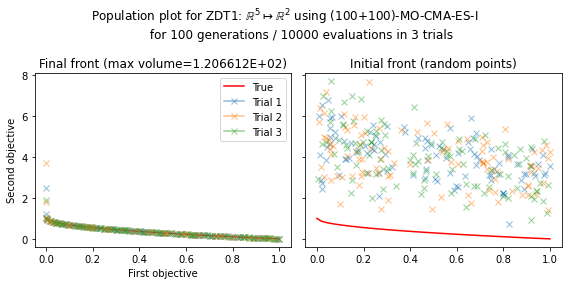

In [4]:
fig = population_plot(lambda rng: benchmark.ZDT1(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     initial_step_size=1.0, reference=np.array([11., 11.]))

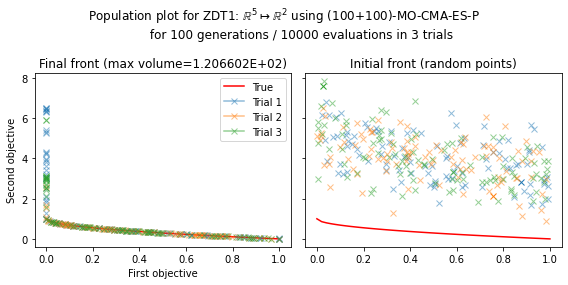

In [5]:
fig = population_plot(lambda rng: benchmark.ZDT1(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, initial_step_size=1.0, reference=np.array([11., 11.]))

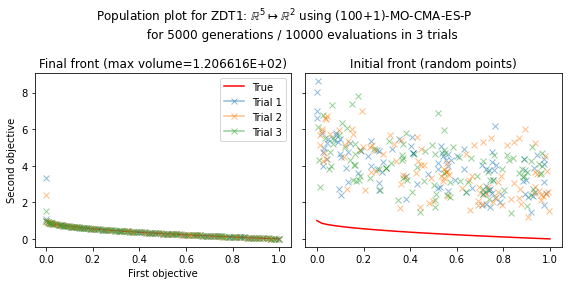

In [6]:
fig = population_plot(lambda rng: benchmark.ZDT1(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, initial_step_size=1.0, reference=np.array([11., 11.]))

### ZDT1, $n=30$

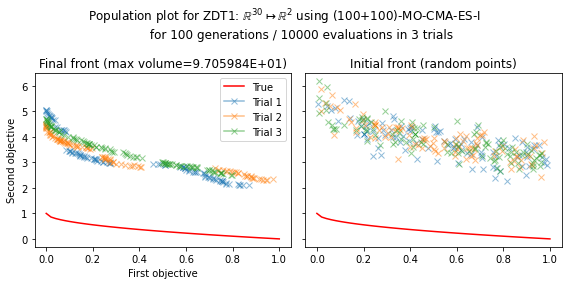

In [7]:
fig = population_plot(lambda rng: benchmark.ZDT1(30, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     initial_step_size=1.0, reference=np.array([11., 11.]))

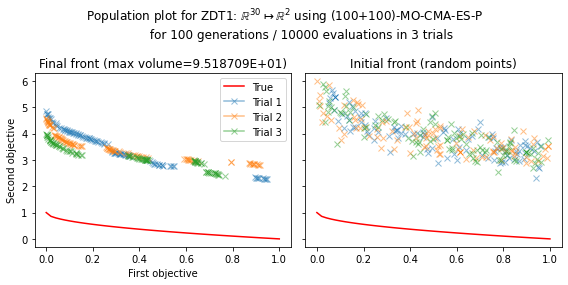

In [8]:
fig = population_plot(lambda rng: benchmark.ZDT1(30, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, initial_step_size=1.0, reference=np.array([11., 11.]))

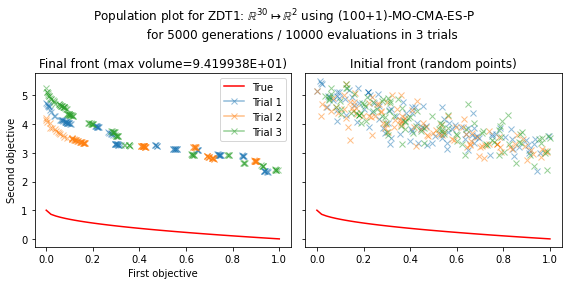

In [9]:
fig = population_plot(lambda rng: benchmark.ZDT1(30, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, initial_step_size=1.0, reference=np.array([11., 11.]))

### ZDT2

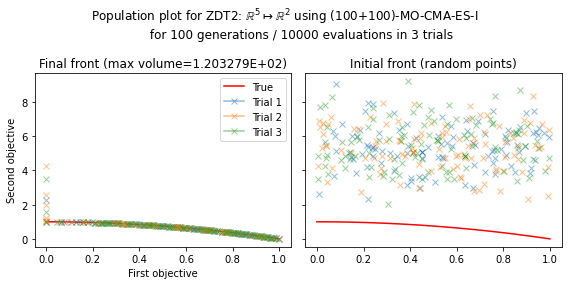

In [10]:
fig = population_plot(lambda rng: benchmark.ZDT2(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     reference=np.array([11., 11.]))

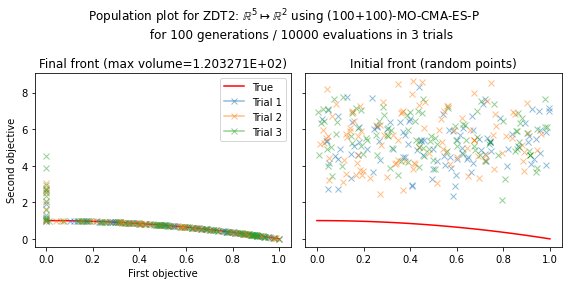

In [11]:
fig = population_plot(lambda rng: benchmark.ZDT2(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

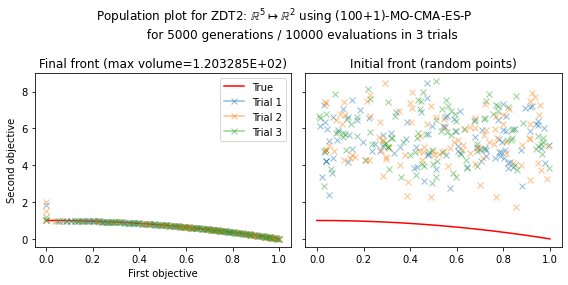

In [12]:
fig = population_plot(lambda rng: benchmark.ZDT2(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### ZDT3

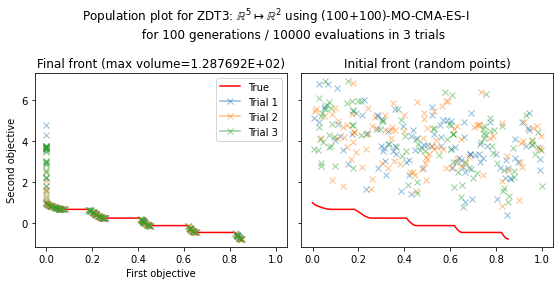

In [13]:
fig = population_plot(lambda rng: benchmark.ZDT3(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     reference=np.array([11., 11.]))

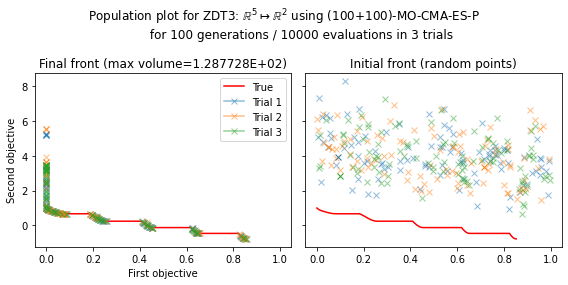

In [14]:
fig = population_plot(lambda rng: benchmark.ZDT3(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

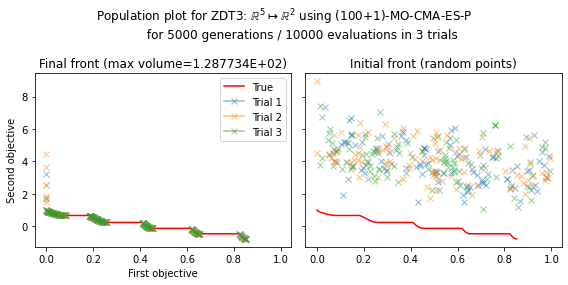

In [15]:
fig = population_plot(lambda rng: benchmark.ZDT3(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### ZDT4

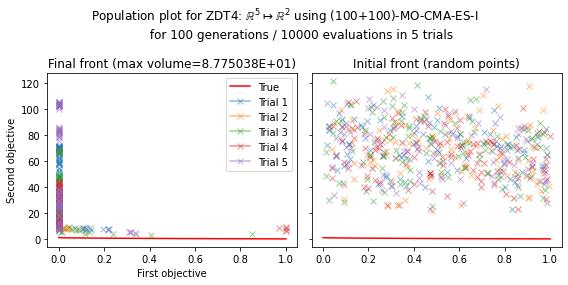

In [16]:
fig = population_plot(lambda rng: benchmark.ZDT4(5, rng=rng), n_trials=5, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

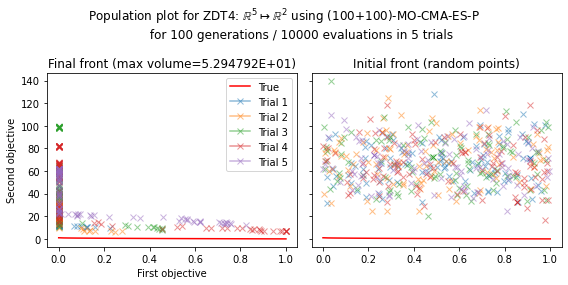

In [17]:
fig = population_plot(lambda rng: benchmark.ZDT4(5, rng=rng), n_trials=5, n_parents=100, max_evaluations=10000,
                      success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

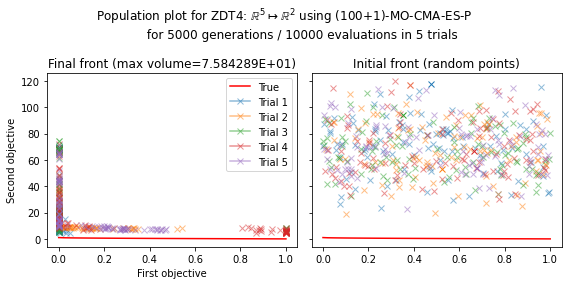

In [18]:
fig = population_plot(lambda rng: benchmark.ZDT4(5, rng=rng), n_trials=5, n_parents=100, n_offspring=1, max_evaluations=10000,
                      success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### ZDT6

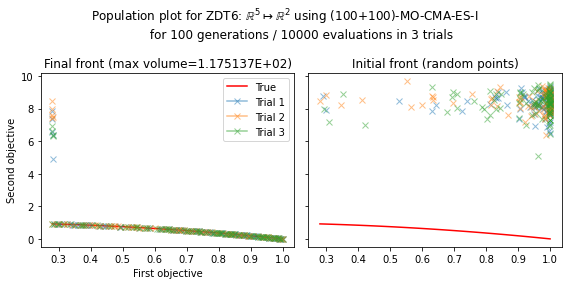

In [19]:
fig = population_plot(lambda rng: benchmark.ZDT6(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

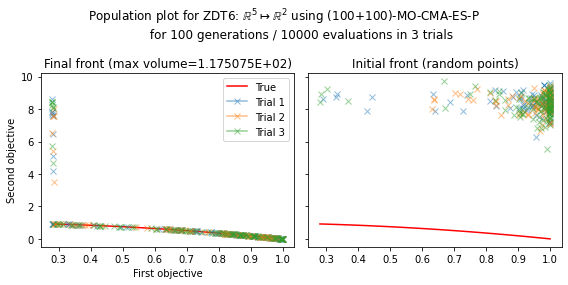

In [20]:
fig = population_plot(lambda rng: benchmark.ZDT6(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

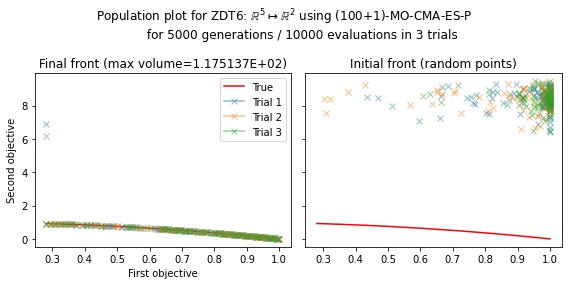

In [21]:
fig = population_plot(lambda rng: benchmark.ZDT6(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### ZDT4P

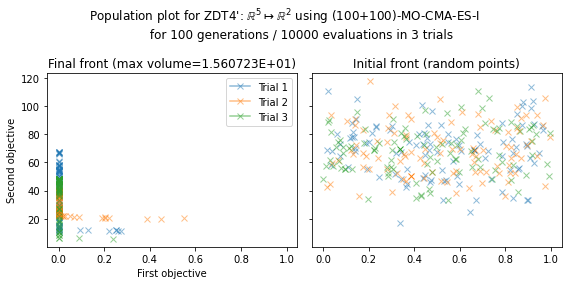

In [22]:
fig = population_plot(lambda rng: benchmark.ZDT4P(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased)

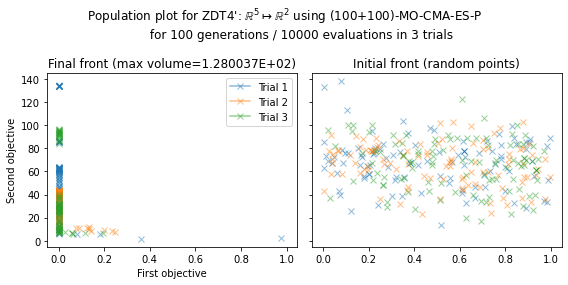

In [23]:
fig = population_plot(lambda rng: benchmark.ZDT4P(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased)

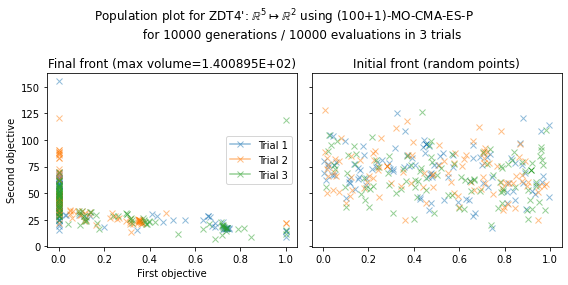

In [24]:
fig = population_plot(lambda rng: benchmark.ZDT4P(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased)

## DTZL benchmark

### DTLZ1

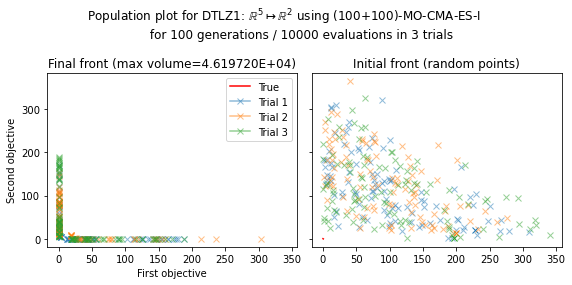

In [25]:
fig = population_plot(lambda rng: benchmark.DTLZ1(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased)

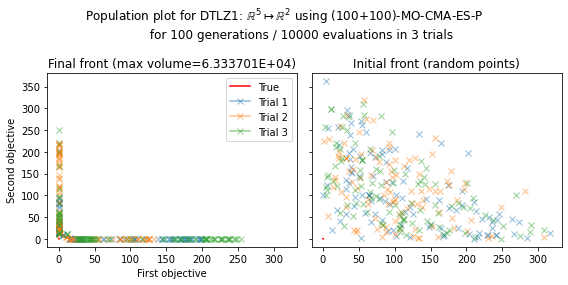

In [26]:
fig = population_plot(lambda rng: benchmark.DTLZ1(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased)

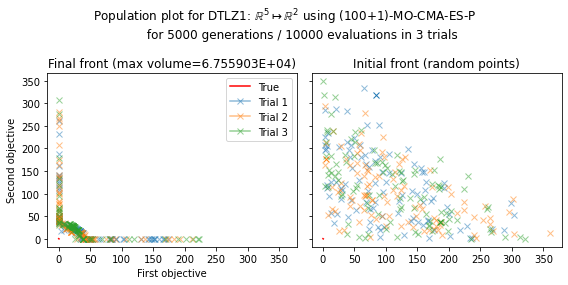

In [27]:
fig = population_plot(lambda rng: benchmark.DTLZ1(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased)

### DTLZ2

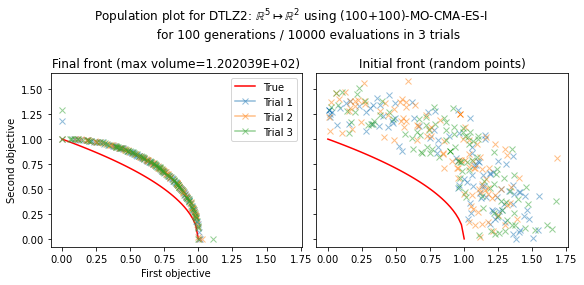

In [28]:
fig = population_plot(lambda rng: benchmark.DTLZ2(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

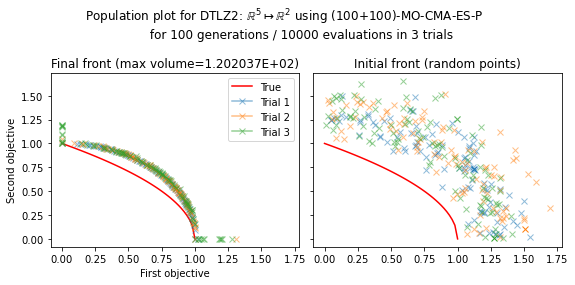

In [29]:
fig = population_plot(lambda rng: benchmark.DTLZ2(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

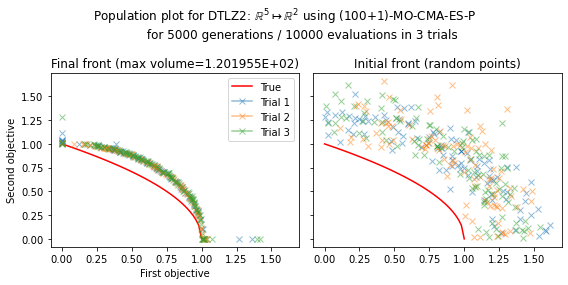

In [30]:
fig = population_plot(lambda rng: benchmark.DTLZ2(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### DTLZ3

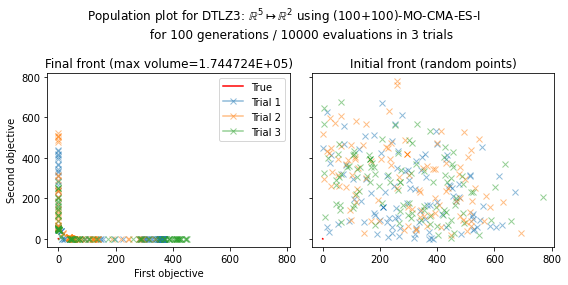

In [31]:
fig = population_plot(lambda rng: benchmark.DTLZ3(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased)

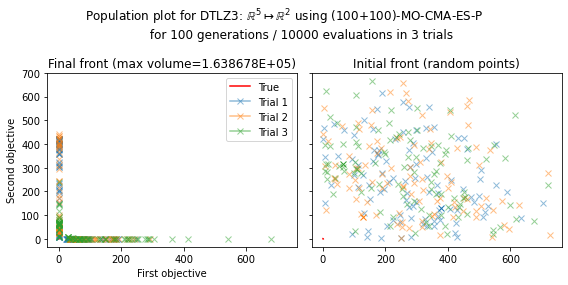

In [32]:
fig = population_plot(lambda rng: benchmark.DTLZ3(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased)

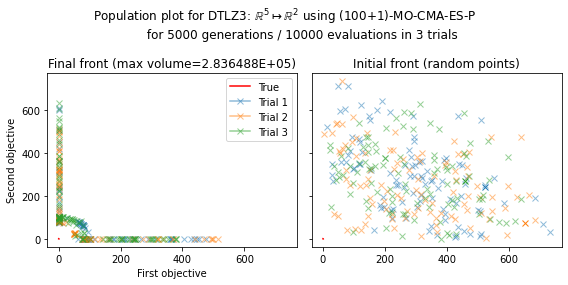

In [33]:
fig = population_plot(lambda rng: benchmark.DTLZ3(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased)

### DTLZ4

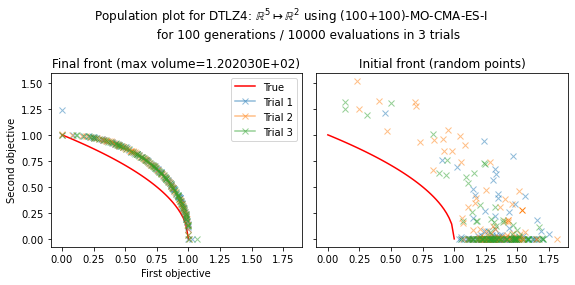

In [34]:
fig = population_plot(lambda rng: benchmark.DTLZ4(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

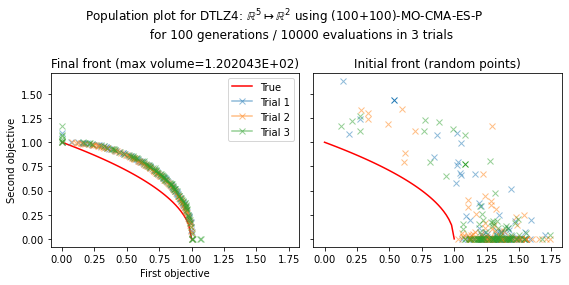

In [35]:
fig = population_plot(lambda rng: benchmark.DTLZ4(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

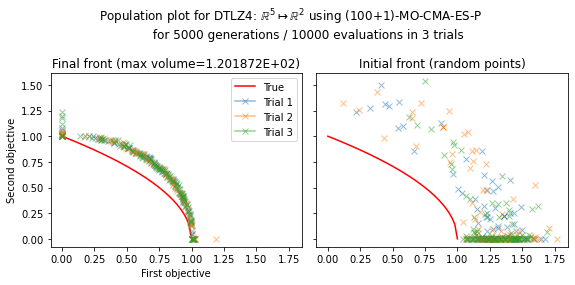

In [36]:
fig = population_plot(lambda rng: benchmark.DTLZ4(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### DTLZ5

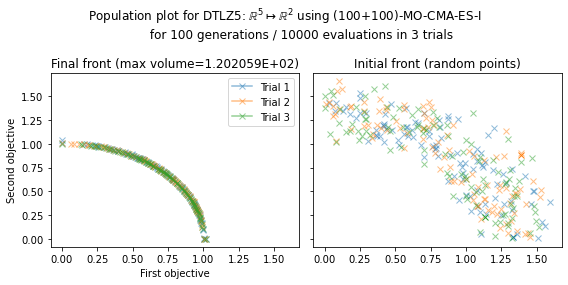

In [37]:
fig = population_plot(lambda rng: benchmark.DTLZ5(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

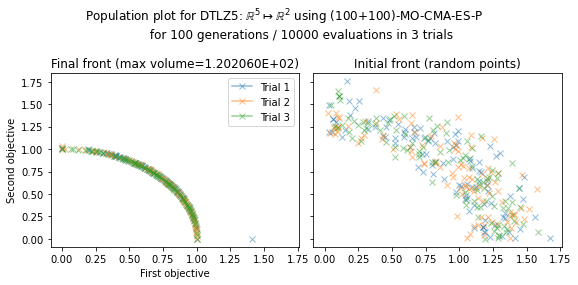

In [38]:
fig = population_plot(lambda rng: benchmark.DTLZ5(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

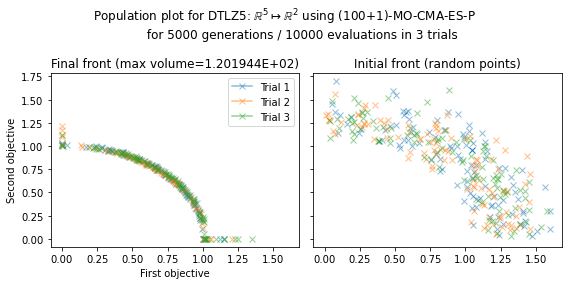

In [39]:
fig = population_plot(lambda rng: benchmark.DTLZ5(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### DTLZ6

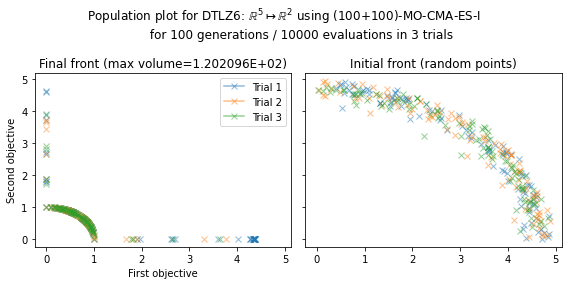

In [40]:
fig = population_plot(lambda rng: benchmark.DTLZ6(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

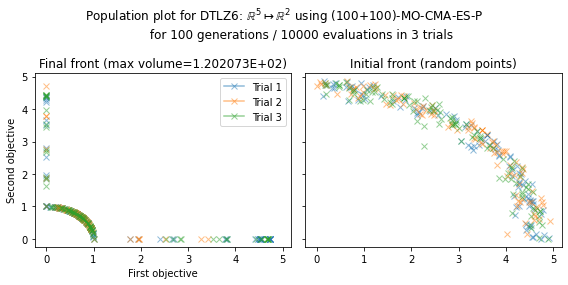

In [41]:
fig = population_plot(lambda rng: benchmark.DTLZ6(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

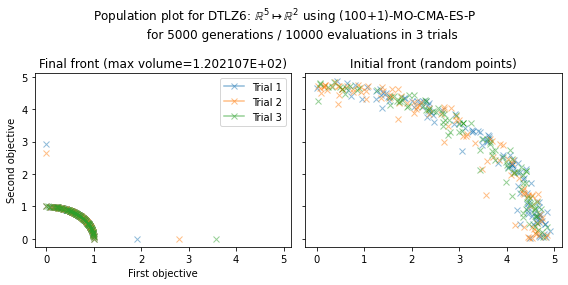

In [42]:
fig = population_plot(lambda rng: benchmark.DTLZ6(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

### DTLZ7

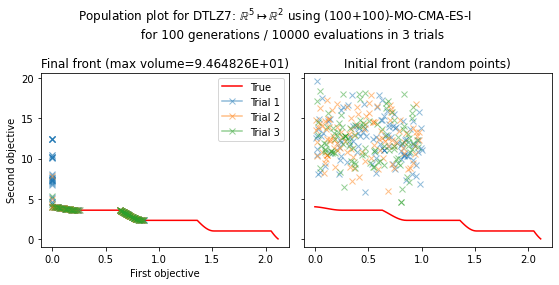

In [43]:
fig = population_plot(lambda rng: benchmark.DTLZ7(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.IndividualBased, reference=np.array([11., 11.]))

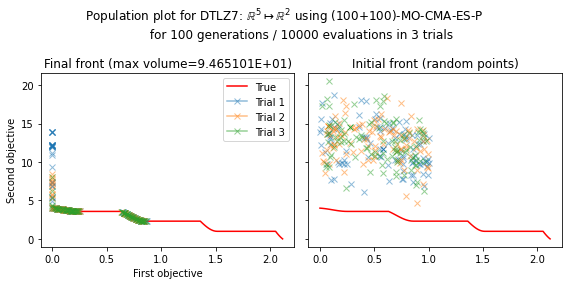

In [44]:
fig = population_plot(lambda rng: benchmark.DTLZ7(5, rng=rng), n_trials=3, n_parents=100, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

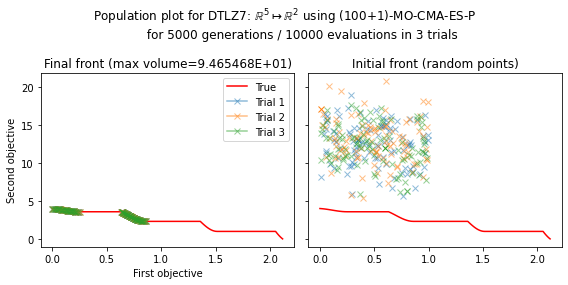

In [45]:
fig = population_plot(lambda rng: benchmark.DTLZ7(5, rng=rng), n_trials=3, n_parents=100, n_offspring=1, max_evaluations=10000,
                     success_notion=SuccessNotion.PopulationBased, reference=np.array([11., 11.]))

## Other benchmark functions

### ELLI1

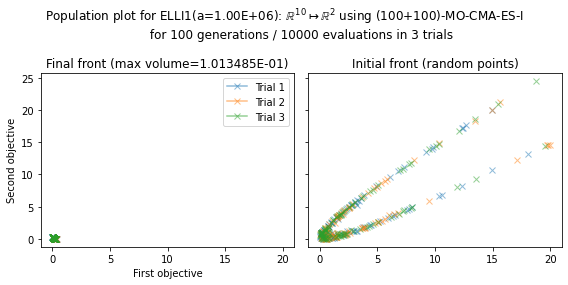

In [46]:
fig = population_plot(lambda rng: benchmark.ELLI1(10, rng=rng), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.IndividualBased, max_evaluations=10000)

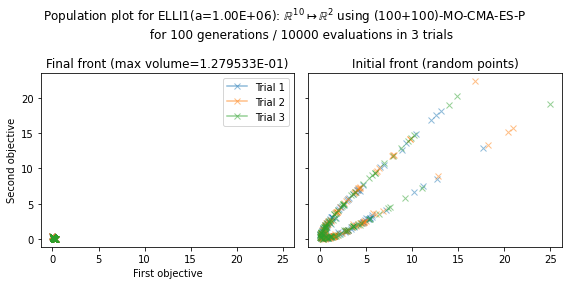

In [47]:
fig = population_plot(lambda rng: benchmark.ELLI1(10, rng=rng), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

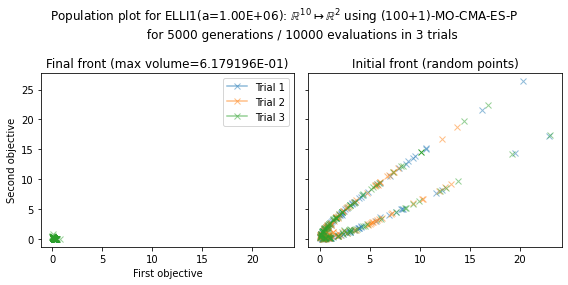

In [48]:
fig = population_plot(lambda rng: benchmark.ELLI1(10, rng=rng), n_trials=3, n_parents=100, n_offspring=1, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

### ELLI2

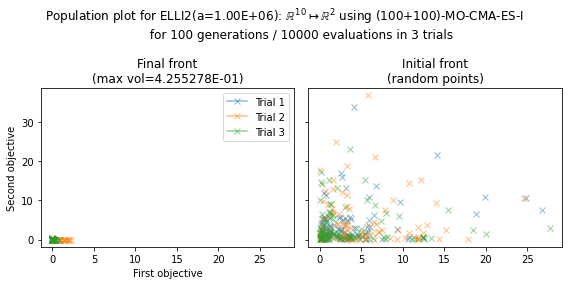

In [4]:
fig = population_plot(lambda rng: benchmark.ELLI2(10, rng=rng), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.IndividualBased, max_evaluations=10000)

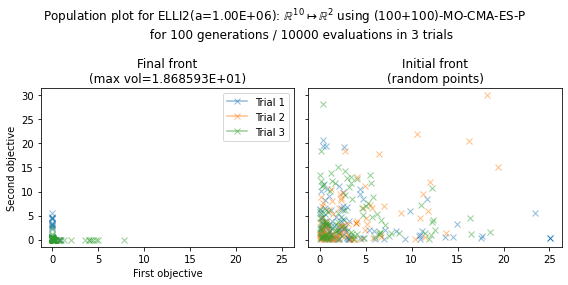

In [5]:
fig = population_plot(lambda rng: benchmark.ELLI2(10, rng=rng), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

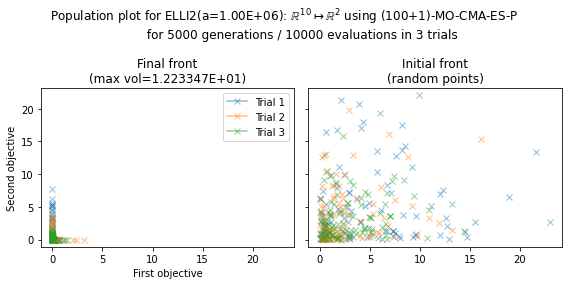

In [3]:
fig = population_plot(lambda rng: benchmark.ELLI2(10, rng=rng), n_trials=3, n_parents=100, n_offspring=1, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

### CIGTAB1

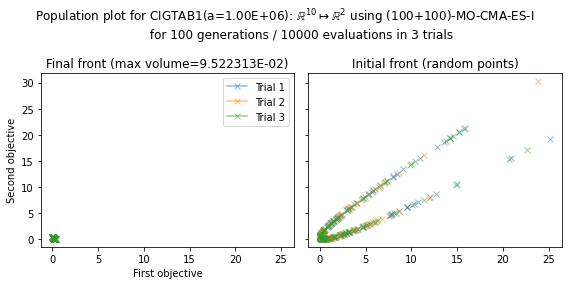

In [52]:
fig = population_plot(lambda rng: benchmark.CIGTAB1(10, rng=rng, a=1e6), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.IndividualBased, max_evaluations=10000)

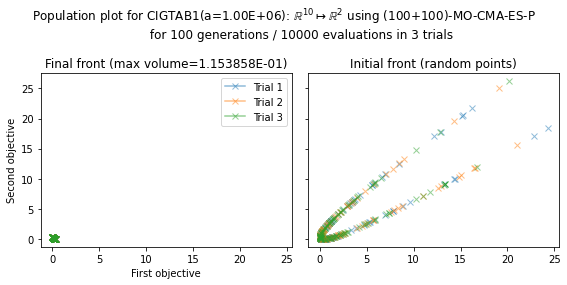

In [53]:
fig = population_plot(lambda rng: benchmark.CIGTAB1(10, rng=rng, a=1e6), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

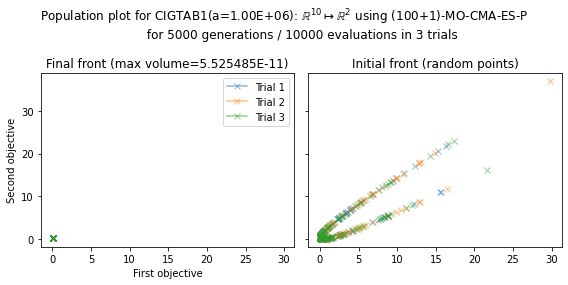

In [54]:
fig = population_plot(lambda rng: benchmark.CIGTAB1(10, rng=rng, a=1e6), n_trials=3, n_parents=100, n_offspring=1, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

### CIGTAB2

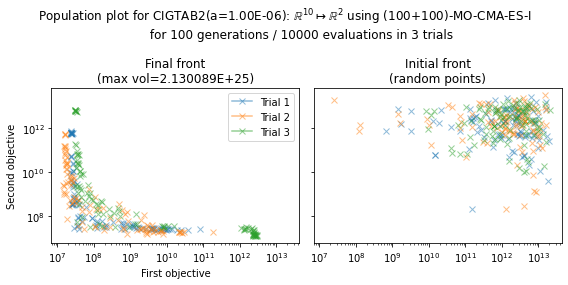

In [75]:
fig = population_plot(lambda rng: benchmark.CIGTAB2(10, rng=rng, a=1e-6), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.IndividualBased, max_evaluations=10000, xscale='log', yscale='log')

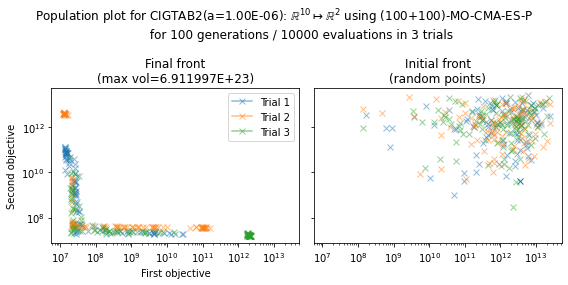

In [76]:
fig = population_plot(lambda rng: benchmark.CIGTAB2(10, rng=rng, a=1e-6), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000, xscale='log', yscale='log')

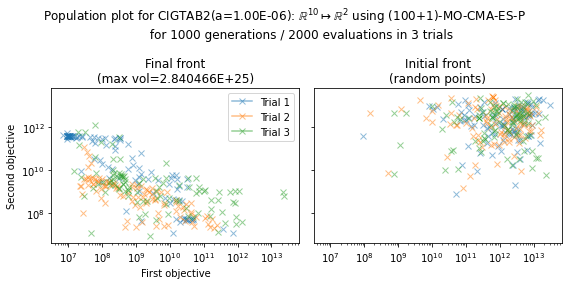

In [12]:
fig = population_plot(lambda rng: benchmark.CIGTAB2(10, rng=rng, a=1e-6), n_trials=3, n_parents=100, n_offspring=1, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=2000, yscale='log', xscale='log')

## FON

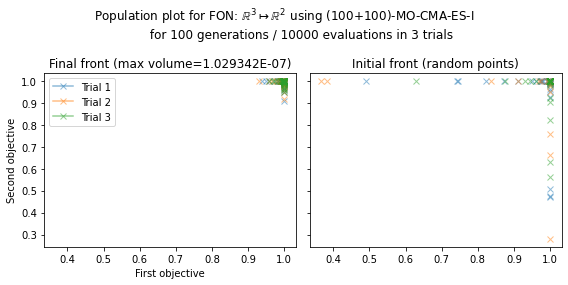

In [58]:
fig = population_plot(lambda rng: benchmark.FON(3, rng=rng), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.IndividualBased, max_evaluations=10000)

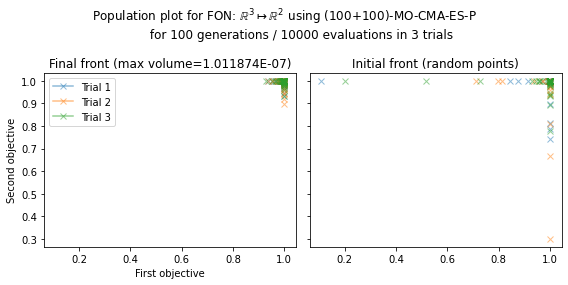

In [59]:
fig = population_plot(lambda rng: benchmark.FON(3, rng=rng), n_trials=3, n_parents=100, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)

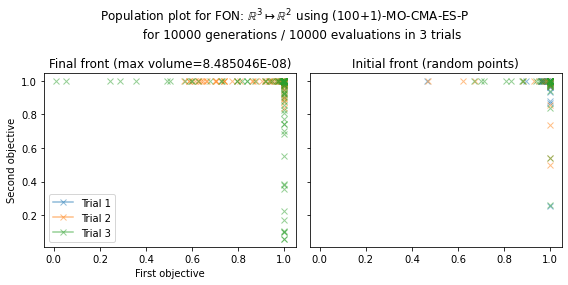

In [60]:
fig = population_plot(lambda rng: benchmark.FON(3, rng=rng), n_trials=3, n_parents=100, n_offspring=1, region_bounds=(-10.0, 10.0),
                     success_notion=SuccessNotion.PopulationBased, max_evaluations=10000)